<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "CGE-Vip"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/CGE-Vip/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


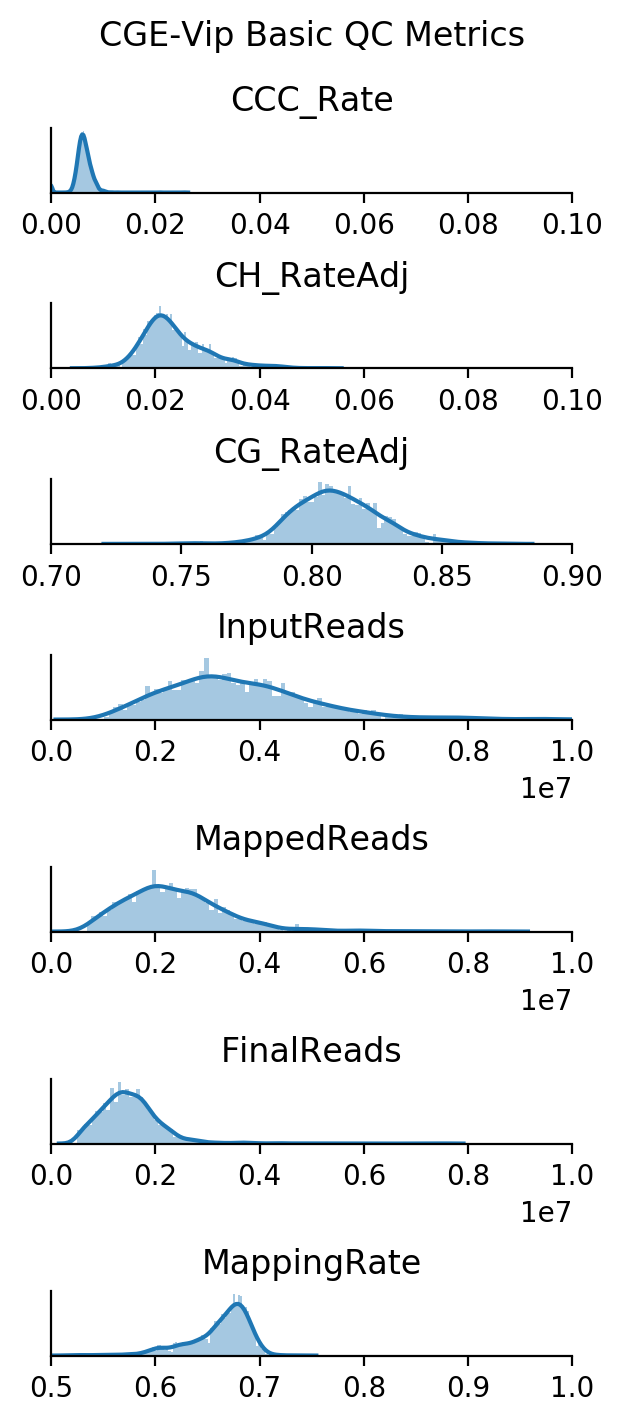

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

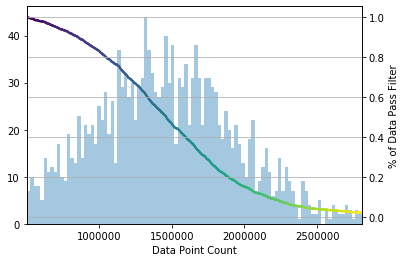

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 1746/1746 (100.0%)
CG_RateAdj passed 1746/1746 (100.0%)
CH_RateAdj passed 1746/1746 (100.0%)
FinalReads passed 1746/1746 (100.0%)
MappingRate passed 1746/1746 (100.0%)
Overall passed 1746/1746 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 8
171207 41
171212 7
171213 50
171214 3
171219 1
180104 22
180109 4
180110 2
180111 1
180119 46
180122 37
180123 34
180129 25
180130 33
180205 31
180206 27
180208 11
180212 10
180213 47
180220 23
180222 18
180226 51
180227 53
180305 28
180306 52
180312 31
180313 5
180319 2
180320 13
180326 11
180329 16
180402 13
180403 16
180405 6
180409 53
180410 50
180412 28
180416 18
180417 14
180419 9
180423 22
180424 15
180426 22
180430 37
180501 32
180514 10
180529 13
180605 24
180612 33
180806 2
180911 1
180917 4
180925 2
181002 20
181008 26
181009 21
181015 2
181016 2
181022 17
181023 17
181204 6
181206 1
181210 21
181218 3
181220 5
190108 20
190117 10
190122 26
190124 23
190131 15
190205 41
190207 1
190212 38
190214 47
190219 32
190305 48
190307 24
190625 17
190627 27
190711 29
190716 40


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 238 62.0%
ad002 217 56.5%
ad004 236 61.5%
ad006 211 54.9%
ad007 217 56.5%
ad008 215 56.0%
ad010 206 53.6%
ad012 206 53.6%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_1540,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006985,0.815133,0.813832,0.038630,0.031868,2057810.0,6132020,3987159.0,10E,...,-2.123653,16.042900,-10.184689,41.748666,CGE-Vip,-21.174679,-12.166444,-20.895260,-28.634748,True
10E_M_1560,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.009671,0.826325,0.824629,0.049657,0.040376,2043560.0,5771766,3800581.0,10E,...,-1.783383,16.513111,-11.708670,41.771733,CGE-Vip,-19.498308,-13.441684,-24.361516,-33.486198,True
10E_M_1667,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.010409,0.818656,0.816749,0.053574,0.043619,1054475.0,2969368,1720342.0,10E,...,-1.876200,16.810942,-12.205589,42.072131,CGE-Vip,-19.499678,-13.628599,-24.095471,-33.954399,True
10E_M_1769,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006202,0.823243,0.822139,0.027297,0.021226,824020.0,2778128,1637654.0,10E,...,-1.954734,18.108671,-13.730333,36.223338,CGE-Vip,-21.276541,-17.113937,-28.258777,-26.741946,True
10E_M_1783,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.008041,0.819596,0.818134,0.043266,0.035511,2073914.0,6215198,3911513.0,10E,...,-2.162773,16.090052,-10.244466,41.791024,CGE-Vip,-21.165464,-12.199821,-20.897319,-28.673269,True
10E_M_1930,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007320,0.810220,0.808821,0.035041,0.027925,1735066.0,5172422,3437958.0,10E,...,-2.218307,16.914085,-11.956507,42.777572,CGE-Vip,-20.104622,-13.671864,-22.410960,-35.391418,True
10E_M_195,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.007431,0.820612,0.819269,0.035095,0.027871,1242362.0,3322232,2091625.0,10E,...,-0.940527,17.999491,-17.692673,40.648865,CGE-Vip,-20.171730,-16.274057,-32.705539,-41.356320,True
10E_M_196,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006108,0.806825,0.805637,0.025243,0.019252,1726591.0,4544526,2947629.0,10E,...,-2.037256,17.072924,-12.331038,42.575313,CGE-Vip,-20.373274,-13.741913,-20.935937,-33.439354,True
10E_M_1964,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.005400,0.779293,0.778095,0.020076,0.014755,3976186.0,10915072,7247094.0,10E,...,-0.859507,17.602886,-16.405446,38.062581,CGE-Vip,-20.486641,-13.296981,-21.364293,-32.990121,True
